(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
Model: "ae_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  401920    
_________________________________________________________________
dense_5 (Dense)              multiple                  10260     
_________________________________________________________________
dense_6 (Dense)              multiple                  10752     
_________________________________________________________________
dense_7 (Dense)              multiple                  402192    
Total params: 825,124
Trainable params: 825,124
Non-trainable params: 0
_________________________________________________________________
Epoch[1/3], Step [50/600], Reconst Loss: 160.8146
Epoch[1/3], Step [100/600], Reconst Loss: 127.1601
Epoch[1/3], Step [150/600], Reconst Loss: 109.0554
Epoch[1/3], Step [200/600], Reconst Loss: 103.8838
E

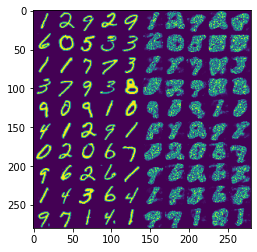

New images saved !
Epoch[2/3], Step [50/600], Reconst Loss: 76.0003
Epoch[2/3], Step [100/600], Reconst Loss: 74.7868
Epoch[2/3], Step [150/600], Reconst Loss: 78.0674
Epoch[2/3], Step [200/600], Reconst Loss: 76.7565
Epoch[2/3], Step [250/600], Reconst Loss: 72.2978
Epoch[2/3], Step [300/600], Reconst Loss: 73.9490
Epoch[2/3], Step [350/600], Reconst Loss: 70.4042
Epoch[2/3], Step [400/600], Reconst Loss: 70.7677
Epoch[2/3], Step [450/600], Reconst Loss: 75.7105
Epoch[2/3], Step [500/600], Reconst Loss: 74.3034
Epoch[2/3], Step [550/600], Reconst Loss: 71.1219
Epoch[2/3], Step [600/600], Reconst Loss: 73.5782


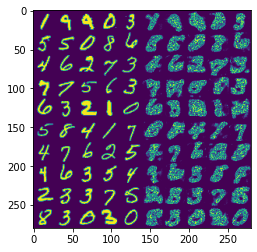

New images saved !
Epoch[3/3], Step [50/600], Reconst Loss: 72.8550
Epoch[3/3], Step [100/600], Reconst Loss: 70.0812
Epoch[3/3], Step [150/600], Reconst Loss: 73.8694
Epoch[3/3], Step [200/600], Reconst Loss: 72.0860
Epoch[3/3], Step [250/600], Reconst Loss: 67.4959
Epoch[3/3], Step [300/600], Reconst Loss: 72.7697
Epoch[3/3], Step [350/600], Reconst Loss: 73.2114
Epoch[3/3], Step [400/600], Reconst Loss: 72.8299
Epoch[3/3], Step [450/600], Reconst Loss: 73.1729
Epoch[3/3], Step [500/600], Reconst Loss: 73.4848
Epoch[3/3], Step [550/600], Reconst Loss: 66.8385
Epoch[3/3], Step [600/600], Reconst Loss: 70.5695


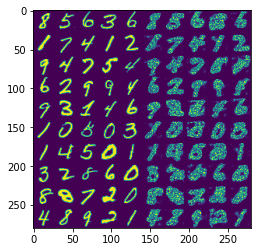

New images saved !


In [2]:
import  os
import  tensorflow as tf
import  numpy as np
from    tensorflow import keras
from    PIL import Image
from    matplotlib import pyplot as plt


tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')




(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train.astype(np.float32) / 255., x_test.astype(np.float32) / 255.



# In[19]:


print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


# image grid
new_im = Image.new('L', (280, 280))

image_size = 28*28
h_dim = 20
num_epochs = 3
batch_size = 100
learning_rate = 1e-3


class AE(tf.keras.Model):

    def __init__(self):
        super(AE, self).__init__()

        # 784 => 512
        self.fc1 = keras.layers.Dense(512)
        # 512 => h
        self.fc2 = keras.layers.Dense(h_dim)

        # h => 512
        self.fc3 = keras.layers.Dense(512)
        # 512 => image
        self.fc4 = keras.layers.Dense(image_size)

    def encode(self, x):
        x = tf.nn.relu(self.fc1(x))
        x = (self.fc2(x))
        return x



    def decode_logits(self, h):
        x = tf.nn.relu(self.fc3(h))
        x = self.fc4(x)

        return x

    def decode(self, h):
        return tf.nn.sigmoid(self.decode_logits(h))

    def call(self, inputs, training=None, mask=None):
        # encoder
        h = self.encode(inputs)
        # decode
        x_reconstructed_logits = self.decode_logits(h)

        return x_reconstructed_logits


model = AE()
model.build(input_shape=(4, image_size))
model.summary()
optimizer = keras.optimizers.Adam(learning_rate)

# we do not need label
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(batch_size * 5).batch(batch_size)

num_batches = x_train.shape[0] // batch_size

for epoch in range(num_epochs):

    for step, x in enumerate(dataset):

        x = tf.reshape(x, [-1, image_size])

        with tf.GradientTape() as tape:

            # Forward pass
            x_reconstruction_logits = model(x)

            # Compute reconstruction loss and kl divergence
            # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
            # Scaled by `image_size` for each individual pixel.
            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / batch_size

        gradients = tape.gradient(reconstruction_loss, model.trainable_variables) 
        gradients,_ = tf.clip_by_global_norm(gradients, 15)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if (step + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, step + 1, num_batches, float(reconstruction_loss)))



     # Save the reconstructed images of last batch
    out_logits = model(x[:batch_size // 2])
    out = tf.nn.sigmoid(out_logits)  # out is just the logits, use sigmoid
    out = tf.reshape(out, [-1, 28, 28]).numpy() * 255

    x = tf.reshape(x[:batch_size // 2], [-1, 28, 28])

    x_concat = tf.concat([x, out], axis=0).numpy() * 255.
    x_concat = x_concat.astype(np.uint8)

    index = 0
    for i in range(0, 280, 28):
        for j in range(0, 280, 28):
            im = x_concat[index]
            im = Image.fromarray(im, mode='L')
            new_im.paste(im, (i, j))
            index += 1

    new_im.save('images/vae_reconstructed_epoch_%d.png' % (epoch + 1))
    plt.imshow(np.asarray(new_im))
    plt.show()
    print('New images saved !')